# Congestion Forecasting in Chicago

## Import libraries

In [1]:
import requests
import pandas as pd
import numpy as np
import folium
import geojson
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.feature_selection import mutual_info_regression, r_regression
from prettytable import PrettyTable
from warnings import filterwarnings
filterwarnings('ignore')


### Load dataset

In [2]:
url = 'https://data.cityofchicago.org/resource/kf7e-cur8.json'

params = {
    '$limit': 1000000,
    '$where': 'time >= "2020-01-01T00:00:00.000" AND time < "2023-03-31T00:00:00.000" AND (region_id== 4 OR region_id== 3 OR region_id== 2 OR region_id== 1)'
}

respons = requests.get(url, params=params)

In [271]:
traffic_data=pd.DataFrame(respons.json())
traffic_data

,time,region_id,speed,region,bus_count,num_reads,hour,day_of_week,month,description,record_id,west,east,south,north,nw_location,se_location
0,2020-01-01T00:01:27.000,1,26.59,Rogers Park - West Ridge,10,215,0,4,1,North of Devon. Kedzie to Lake Shore,01-202001010601,-87.709645,-87.654561,41.997946,42.026444,"{'type': 'Point', 'coordinates': [-87.709645, ...","{'type': 'Point', 'coordinates': [-87.654561, ..."
1,2020-01-01T00:01:27.000,2,35.66,Far North West,10,148,0,4,1,North of Montrose. East River to Cicero,02-202001010601,-87.84621,-87.747456,41.960669,42.0190998,"{'type': 'Point', 'coordinates': [-87.84621, 4...","{'type': 'Point', 'coordinates': [-87.747456, ..."
2,2020-01-01T00:01:27.000,3,23.86,North Park-Albany-Linconl Sq,27,399,0,4,1,Montrose to Devon. Cicero to Ravenswood,03-202001010601,-87.747456,-87.67459,41.960669,41.997946,"{'type': 'Point', 'coordinates': [-87.747456, ...","{'type': 'Point', 'coordinates': [-87.67459, 4..."
3,2020-01-01T00:01:27.000,4,26.11,Edge Water-Uptown,10,248,0,4,1,Montrose to Devon. Ravenswood to Lake Shore,04-202001010601,-87.67459,-87.646438,41.960669,41.997946,"{'type': 'Point', 'coordinates': [-87.67459, 4...","{'type': 'Point', 'coordinates': [-87.646438, ..."
4,2020-01-01T00:10:47.000,1,26.59,Rogers Park - West Ridge,10,201,0,4,1,North of Devon. Kedzie to Lake Shore,01-202001010610,-87.709645,-87.654561,41.997946,42.026444,"{'type': 'Point', 'coordinates': [-87.709645, ...","{'type': 'Point', 'coordinates': [-87.654561, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606305,2023-03-30T23:40:37.000,4,25.23,Edge Water-Uptown,12,284,23,5,3,Montrose to Devon. Ravenswood to Lake Shore,04-202303310440,-87.67459,-87.646438,41.960669,41.997946,"{'type': 'Point', 'coordinates': [-87.67459, 4...","{'type': 'Point', 'coordinates': [-87.646438, ..."
606306,2023-03-30T23:50:38.000,1,29.73,Rogers Park - West Ridge,8,189,23,5,3,North of Devon. Kedzie to Lake Shore,01-202303310450,-87.709645,-87.654561,41.997946,42.026444,"{'type': 'Point', 'coordinates': [-87.709645, ...","{'type': 'Point', 'coordinates': [-87.654561, ..."
606307,2023-03-30T23:50:38.000,2,30,Far North West,13,143,23,5,3,North of Montrose. East River to Cicero,02-202303310450,-87.84621,-87.747456,41.960669,42.0190998,"{'type': 'Point', 'coordinates': [-87.84621, 4...","{'type': 'Point', 'coordinates': [-87.747456, ..."
606308,2023-03-30T23:50:38.000,3,27.95,North Park-Albany-Linconl Sq,32,436,23,5,3,Montrose to Devon. Cicero to Ravenswood,03-202303310450,-87.747456,-87.67459,41.960669,41.997946,"{'type': 'Point', 'coordinates': [-87.747456, ...","{'type': 'Point', 'coordinates': [-87.67459, 4..."


In [272]:
traffic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606310 entries, 0 to 606309
Data columns (total 17 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   time         606310 non-null  object
 1   region_id    606310 non-null  object
 2   speed        606310 non-null  object
 3   region       606310 non-null  object
 4   bus_count    606310 non-null  object
 5   num_reads    606310 non-null  object
 6   hour         606310 non-null  object
 7   day_of_week  606310 non-null  object
 8   month        606310 non-null  object
 9   description  606310 non-null  object
 10  record_id    606310 non-null  object
 11  west         606310 non-null  object
 12  east         606310 non-null  object
 13  south        606310 non-null  object
 14  north        606310 non-null  object
 15  nw_location  606310 non-null  object
 16  se_location  606310 non-null  object
dtypes: object(17)
memory usage: 78.6+ MB


In [273]:
locdata= traffic_data.head(4)[['region', 'west','east','south', 'north']]
locdata[['west','east','south', 'north']]=locdata[['west','east','south', 'north']].astype(float)
locdata

,region,west,east,south,north
0,Rogers Park - West Ridge,-87.709645,-87.654561,41.997946,42.026444
1,Far North West,-87.846210,-87.747456,41.960669,42.019100
2,North Park-Albany-Linconl Sq,-87.747456,-87.674590,41.960669,41.997946
3,Edge Water-Uptown,-87.674590,-87.646438,41.960669,41.997946


In [274]:
# Define the coordinates of four different regions in Chicago
# Region 1
region1_west, region1_east, region1_south, region1_north = locdata.loc[0][1], locdata.loc[0][2], locdata.loc[0][3], locdata.loc[0][4]
region1 = Polygon([(region1_west, region1_south), (region1_east, region1_south), (region1_east, region1_north), (region1_west, region1_north), (region1_west, region1_south)])
# Region 2
region2_west, region2_east, region2_south, region2_north = locdata.loc[1][1], locdata.loc[1][2], locdata.loc[1][3], locdata.loc[1][4]
region2 = Polygon([(region2_west, region2_south), (region2_east, region2_south), (region2_east, region2_north), (region2_west, region2_north), (region2_west, region2_south)])
# Region 3
region3_west, region3_east, region3_south, region3_north = locdata.loc[2][1], locdata.loc[2][2], locdata.loc[2][3], locdata.loc[2][4]
region3 = Polygon([(region3_west, region3_south), (region3_east, region3_south), (region3_east, region3_north), (region3_west, region3_north), (region3_west, region3_south)])
#Region 4
region4_west, region4_east, region4_south, region4_north = locdata.loc[3][1], locdata.loc[3][2], locdata.loc[3][3], locdata.loc[3][4]
region4 = Polygon([(region4_west, region4_south), (region4_east, region4_south), (region4_east, region4_north), (region4_west, region4_north), (region4_west, region4_south)])

# Convert the Polygons to Feature objects
feature1 = geojson.Feature(geometry=region1, properties={'Name': locdata.loc[0][0]})
feature2 = geojson.Feature(geometry=region2, properties={'Name': locdata.loc[1][0]})
feature3 = geojson.Feature(geometry=region3, properties={'Name': locdata.loc[2][0]})
feature4 = geojson.Feature(geometry=region4, properties={'Name': locdata.loc[3][0]})

# Create a FeatureCollection object
feature_collection = geojson.FeatureCollection([feature1, feature2, feature3, feature4])

# Create a folium Map centered at the centroid of the regions
m = folium.Map(location=[region1.centroid.y, region3.centroid.x], zoom_start=12.45)


def style_function(feature):
    return {'fillColor': 'blue', 'color': 'blue', 'weight': 1.5, 'fillOpacity': 0.2}



def create_region_icon(name):
    return folium.features.DivIcon(
        icon_size=(150,36),
        icon_anchor=(0,0),
        html=f'<div style="font-size: 14pt; color: black;">{name}</div>'
    )


# Add the GeoJSON data to the map with a custom popup
folium.GeoJson(feature_collection, 
               style_function=style_function, 
               popup=folium.GeoJsonPopup(fields=['Name'], aliases=['<span style="color: blue;">Region Name:</span>'])
              ).add_to(m)

# Iterate through the features and add markers with the custom icon and tooltip
for feature in feature_collection['features']:
    name = feature['properties']['Name']
    coords = feature['geometry']['coordinates'][0]
    center_lat = sum(p[1] for p in coords) / len(coords)
    center_lon = sum(p[0] for p in coords) / len(coords)
    folium.Marker(location=[center_lat, center_lon], icon=create_region_icon(name), tooltip=name).add_to(m)


# Display the map
m


In [275]:
# Extract required columns
traffic_df = traffic_data[['time', 'region_id', 'speed', 'bus_count', 'hour', 'day_of_week', 'month']].copy()
traffic_df['time']=pd.to_datetime(traffic_df['time'], yearfirst=True)
traffic_df.set_index('time', drop=True, inplace=True)
traffic_df

,region_id,speed,bus_count,hour,day_of_week,month
time,,,,,,
2020-01-01 00:01:27,1,26.59,10,0,4,1
2020-01-01 00:01:27,2,35.66,10,0,4,1
2020-01-01 00:01:27,3,23.86,27,0,4,1
2020-01-01 00:01:27,4,26.11,10,0,4,1
2020-01-01 00:10:47,1,26.59,10,0,4,1
...,...,...,...,...,...,...
2023-03-30 23:40:37,4,25.23,12,23,5,3
2023-03-30 23:50:38,1,29.73,8,23,5,3
2023-03-30 23:50:38,2,30,13,23,5,3


In [276]:
# Change data types
traffic_df[['speed']]=traffic_df[['speed']].astype(float)
traffic_df[['region_id', 'bus_count', 'hour', 'day_of_week', 'month']]=traffic_df[['region_id', 'bus_count', 'hour', 'day_of_week', 'month']].astype(int)
traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 606310 entries, 2020-01-01 00:01:27 to 2023-03-30 23:50:38
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   region_id    606310 non-null  int32  
 1   speed        606310 non-null  float64
 2   bus_count    606310 non-null  int32  
 3   hour         606310 non-null  int32  
 4   day_of_week  606310 non-null  int32  
 5   month        606310 non-null  int32  
dtypes: float64(1), int32(5)
memory usage: 20.8 MB


In [277]:
# Group the data by region
regions = traffic_df.copy().groupby('region_id')

In [278]:
# Extract data for each street
Rogers_Park_West_Ridge = regions.get_group(1)
Far_North_West = regions.get_group(2)
North_Park_Albany_Linconl_Sq = regions.get_group(3)
Edge_Water_Uptown = regions.get_group(4)

##### Summary statistics

In [279]:
Rogers_Park_West_Ridge.describe()

,region_id,speed,bus_count,hour,day_of_week,month
count,151578.0,151578.000000,151578.000000,151578.000000,151578.000000,151578.000000
mean,1.0,20.957481,18.908120,11.495395,4.005040,6.068941
std,0.0,8.931062,10.794093,6.920975,2.000502,3.499413
min,1.0,0.000000,0.000000,0.000000,1.000000,1.000000
25%,1.0,22.500000,10.000000,5.000000,2.000000,3.000000
50%,1.0,23.860000,20.000000,11.000000,4.000000,6.000000
75%,1.0,25.230000,27.000000,17.000000,6.000000,9.000000
max,1.0,81.140000,54.000000,23.000000,7.000000,12.000000


In [280]:
Far_North_West.describe()

,region_id,speed,bus_count,hour,day_of_week,month
count,151578.0,151578.000000,151578.000000,151578.000000,151578.000000,151578.000000
mean,2.0,27.264662,28.484998,11.495408,4.005021,6.068941
std,0.0,7.795478,15.280805,6.920957,2.000487,3.499413
min,2.0,0.000000,0.000000,0.000000,1.000000,1.000000
25%,2.0,27.270000,17.000000,5.000000,2.000000,3.000000
50%,2.0,28.640000,28.000000,11.000000,4.000000,6.000000
75%,2.0,30.000000,41.000000,17.000000,6.000000,9.000000
max,2.0,173.860000,86.000000,23.000000,7.000000,12.000000


In [281]:
North_Park_Albany_Linconl_Sq.describe()

,region_id,speed,bus_count,hour,day_of_week,month
count,151576.0,151576.000000,151576.000000,151576.000000,151576.000000,151576.000000
mean,3.0,23.765547,43.596691,11.495329,4.005007,6.068896
std,0.0,5.064194,23.322792,6.920968,2.000484,3.499410
min,3.0,0.000000,0.000000,0.000000,1.000000,1.000000
25%,3.0,21.820000,26.000000,5.000000,2.000000,3.000000
50%,3.0,23.860000,44.000000,11.000000,4.000000,6.000000
75%,3.0,25.910000,62.000000,17.000000,6.000000,9.000000
max,3.0,173.860000,115.000000,23.000000,7.000000,12.000000


In [282]:
Edge_Water_Uptown.describe()

,region_id,speed,bus_count,hour,day_of_week,month
count,151578.0,151578.000000,151578.000000,151578.000000,151578.000000,151578.000000
mean,4.0,20.288368,29.105543,11.495382,4.005034,6.068948
std,0.0,7.436534,17.407443,6.920940,2.000487,3.499418
min,4.0,0.000000,0.000000,0.000000,1.000000,1.000000
25%,4.0,20.450000,13.000000,5.000000,2.000000,3.000000
50%,4.0,21.820000,31.000000,11.000000,4.000000,6.000000
75%,4.0,23.860000,42.000000,17.000000,6.000000,9.000000
max,4.0,173.520000,87.000000,23.000000,7.000000,12.000000


<Axes: title={'center': 'Edge Water Uptown'}, xlabel='Speed', ylabel='Frequency'>

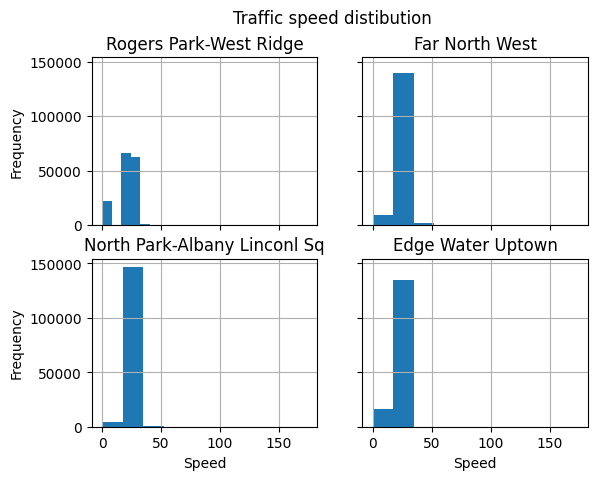

In [283]:
# Plot each region's speed histogram
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
fig.suptitle('Traffic speed distibution')
axes[1,1].set_xlabel('Speed')
axes[1,0].set_xlabel('Speed')

Rogers_Park_West_Ridge.speed.plot(ax=axes[0,0], kind='hist', title='Rogers Park-West Ridge', grid=True)
Far_North_West.speed.plot(ax=axes[0,1], kind='hist', title='Far North West', grid=True)
North_Park_Albany_Linconl_Sq.speed.plot(ax=axes[1,0], kind='hist', title='North Park-Albany Linconl Sq', grid=True)
Edge_Water_Uptown.speed.plot(ax=axes[1,1], kind='hist', title='Edge Water Uptown', grid=True)

### Pattern in the data

Text(0.5, 1.0, 'Edge Water Uptown')

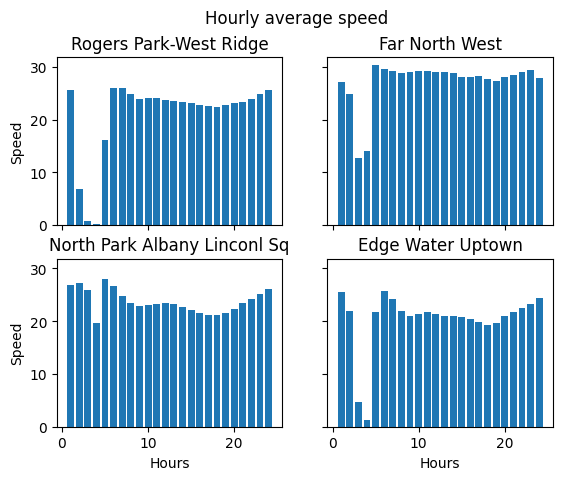

In [296]:
# Hourly average speed
fig, axe = plt.subplots(2, 2, sharex=True, sharey=True)
fig.suptitle('Hourly average speed')
axe[1,1].set_xlabel('Hours')
axe[1,0].set_xlabel('Hours')
axe[0,0].set_ylabel('Speed')
axe[1,0].set_ylabel('Speed')


axe[0,0].bar(range(1,25), Rogers_Park_West_Ridge.groupby('hour')['speed'].mean().values)
axe[0,0].set_title('Rogers Park-West Ridge')
axe[0,1].bar(range(1,25), Far_North_West.groupby('hour')['speed'].mean().values)
axe[0,1].set_title('Far North West')
axe[1,0].bar(range(1,25), North_Park_Albany_Linconl_Sq.groupby('hour')['speed'].mean().values)
axe[1,0].set_title('North Park Albany Linconl Sq')
axe[1,1].bar(range(1,25), Edge_Water_Uptown.groupby('hour')['speed'].mean().values)
axe[1,1].set_title('Edge Water Uptown')

Text(0.5, 1.0, 'Edge Water Uptown')

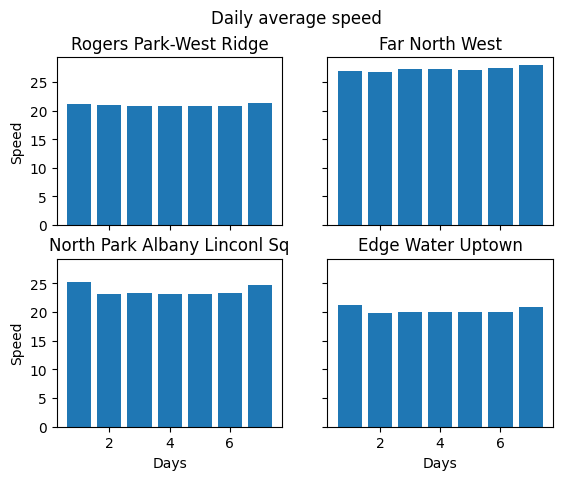

In [297]:
# Daily average speed 
fig, axe = plt.subplots(2, 2, sharex=True, sharey=True)

fig.suptitle('Daily average speed')
axe[1,1].set_xlabel('Days')
axe[1,0].set_xlabel('Days')
axe[0,0].set_ylabel('Speed')
axe[1,0].set_ylabel('Speed')

axe[0,0].bar(range(1,8), Rogers_Park_West_Ridge.groupby('day_of_week')['speed'].mean().values)
axe[0,0].set_title('Rogers Park-West Ridge')
axe[0,1].bar(range(1,8), Far_North_West.groupby('day_of_week')['speed'].mean().values)
axe[0,1].set_title('Far North West')
axe[1,0].bar(range(1,8), North_Park_Albany_Linconl_Sq.groupby('day_of_week')['speed'].mean().values)
axe[1,0].set_title('North Park Albany Linconl Sq')
axe[1,1].bar(range(1,8), Edge_Water_Uptown.groupby('day_of_week')['speed'].mean().values)
axe[1,1].set_title('Edge Water Uptown')

### Autocorrelation

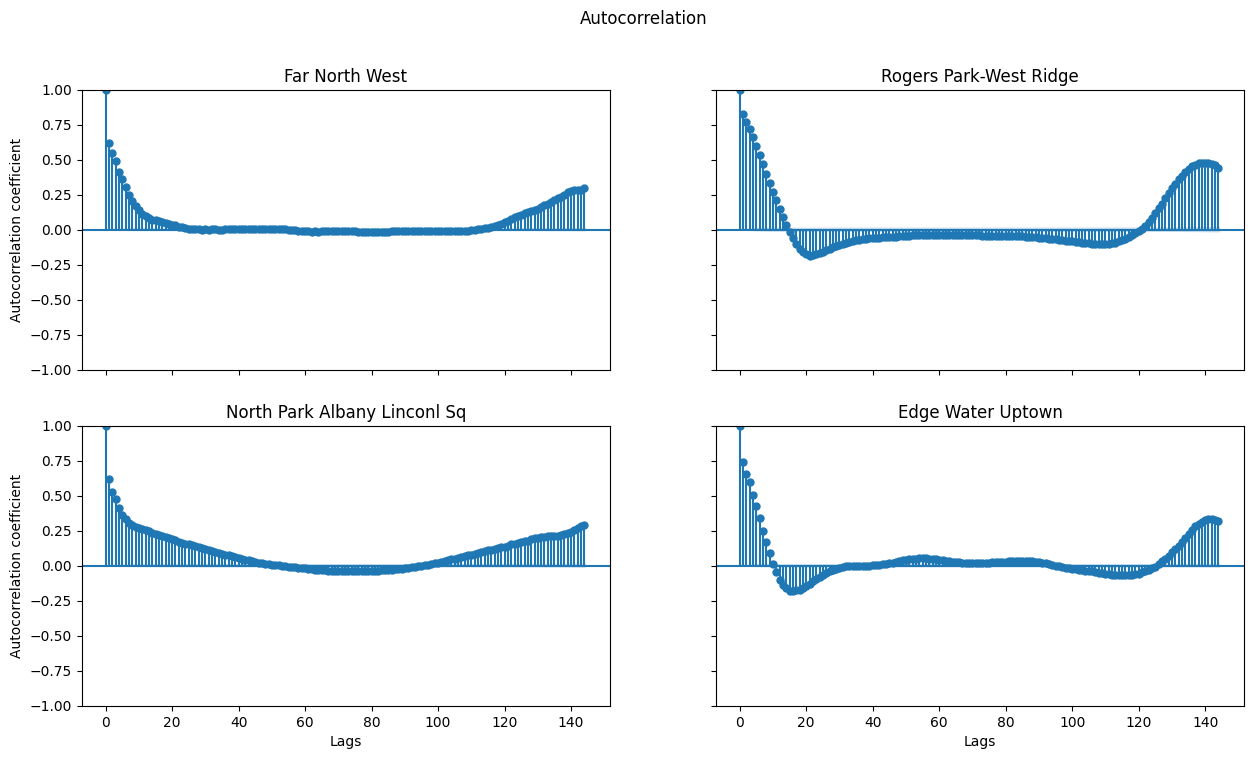

In [298]:
# Autocorrelation
fig, axe = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(15, 8))
fig.suptitle('Autocorrelation')
axe[1,1].set_xlabel('Lags')
axe[1,0].set_xlabel('Lags')
axe[0,0].set_ylabel('Autocorrelation coefficient')
axe[1,0].set_ylabel('Autocorrelation coefficient')

plot_acf(Rogers_Park_West_Ridge.speed, lags=144, ax=axe[0,1], title='Rogers Park-West Ridge')
plot_acf(Far_North_West.speed, lags=144, ax=axe[0,0], title='Far North West')
plot_acf(North_Park_Albany_Linconl_Sq.speed, lags=144, ax=axe[1,0], title='North Park Albany Linconl Sq')
plot_acf(Edge_Water_Uptown.speed, lags=144, ax=axe[1,1], title='Edge Water Uptown')
plt.show()

### Correlation matrices of features

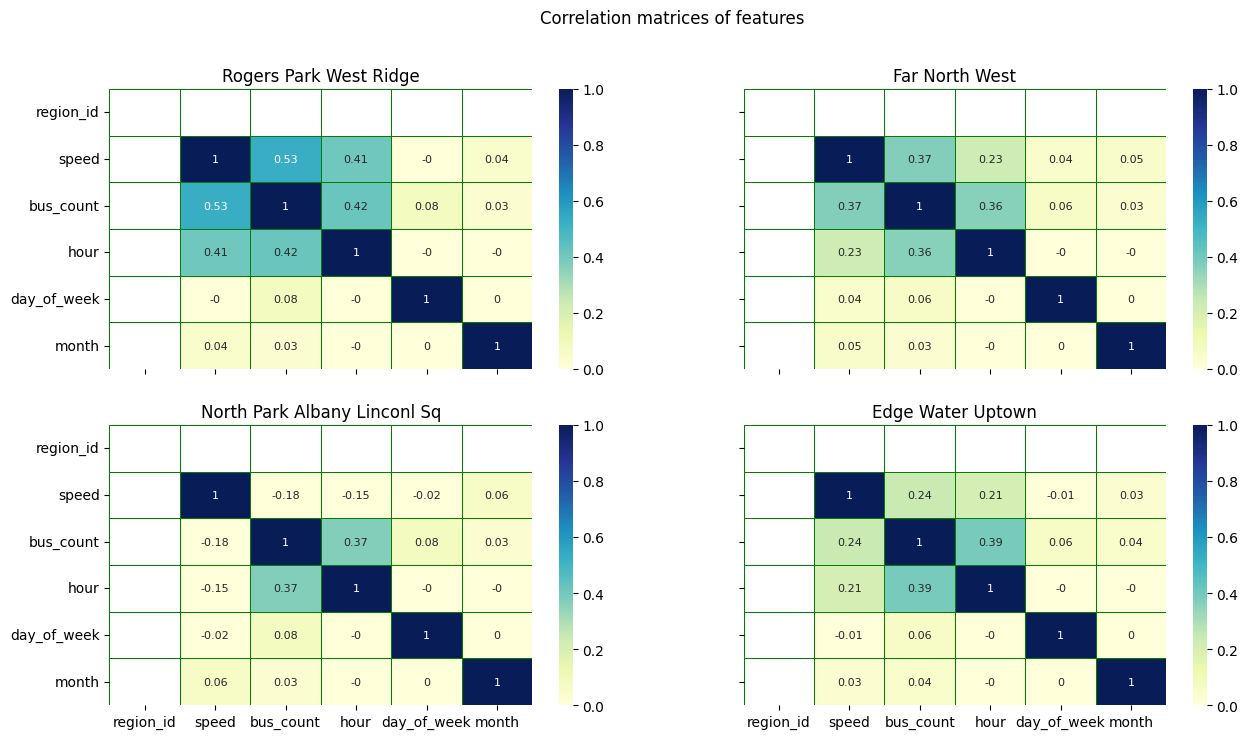

In [299]:
fig, axe = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(15, 8))
fig.suptitle('Correlation matrices of features')

# Rogers Park West Ridge
Rogers_Park_West_Ridge_heat=Rogers_Park_West_Ridge.corr()
sns.heatmap(round(Rogers_Park_West_Ridge_heat,2),vmin=0,vmax=1 ,linewidths=0.5 ,cmap="YlGnBu",\
            annot=True,linecolor='green',annot_kws={'size': 8}, ax=axe[0,0])
axe[0, 0].set_title("Rogers Park West Ridge")

# Far North West
Far_North_West_heat=Far_North_West.corr()
sns.heatmap(round(Far_North_West_heat,2),vmin=0,vmax=1 ,linewidths=0.5 ,cmap="YlGnBu",\
            annot=True,linecolor='green',annot_kws={'size': 8}, ax=axe[0,1])
axe[0, 1].set_title("Far North West")

# North Park Albany Linconl Sq
North_Park_Albany_Linconl_Sq_heat=North_Park_Albany_Linconl_Sq.corr()
sns.heatmap(round(North_Park_Albany_Linconl_Sq_heat,2),vmin=0,vmax=1 ,linewidths=0.5 ,cmap="YlGnBu",\
            annot=True,linecolor='green',annot_kws={'size': 8}, ax=axe[1,0])
axe[1, 0].set_title("North Park Albany Linconl Sq")

# Edge Water Uptown
Edge_Water_Uptown_heat=Edge_Water_Uptown.corr()
sns.heatmap(round(Edge_Water_Uptown_heat,2),vmin=0,vmax=1 ,linewidths=0.5 ,cmap="YlGnBu",\
            annot=True,linecolor='green',annot_kws={'size': 8}, ax=axe[1,1])
axe[1, 1].set_title("Edge Water Uptown")
plt.show()

### Feature selection and engineering

### Feature selection

#### North Park Albany Linconl Sq

In [300]:
X=North_Park_Albany_Linconl_Sq.iloc[:,2:]
y=North_Park_Albany_Linconl_Sq.speed

mutual_info_north = mutual_info_regression(X, y)  # mutual_info_regression
r_reg_north = r_regression(X, y)                  #r_regression

#### Rogers Park West Ridge

In [301]:
X=Rogers_Park_West_Ridge.iloc[:,2:]
y=Rogers_Park_West_Ridge.speed

mutual_info_west = mutual_info_regression(X, y)  # mutual_info_regression
r_reg_west = r_regression(X, y)     #r_regression

#### Far North West

In [302]:
X=Far_North_West.iloc[:,2:]
y=Far_North_West.speed

mutual_info_Nwest = mutual_info_regression(X, y)  # mutual_info_regression
r_reg_Nwest = r_regression(X, y)                  #f_regression

#### Edge Water Uptown

In [303]:
X=Edge_Water_Uptown.iloc[:,2:]
y=Edge_Water_Uptown.speed

mutual_info_water = mutual_info_regression(X, y)  # mutual_info_regression
r_reg_water = r_regression(X, y)                      #f_regression


In [304]:
Feature_scores_mi = PrettyTable(["Road", "bus_count", "hour", "day_of_week", "month"])
# Add rows
Feature_scores_mi.add_row(["North Park Albany Linconl Sq", round(mutual_info_north[0],4), round(mutual_info_north[1],4),\
                 round(mutual_info_north[2],4),round(mutual_info_north[3],4)])
Feature_scores_mi.add_row(["Rogers Park West Ridge", round(mutual_info_west[0],4), round(mutual_info_west[1],4),\
                 round(mutual_info_west[2],4),round(mutual_info_west[3],4)])
Feature_scores_mi.add_row(["Far North West", round(mutual_info_Nwest[0],4), round(mutual_info_Nwest[1],4),\
                 round(mutual_info_Nwest[2],4),round(mutual_info_Nwest[3],4)])
Feature_scores_mi.add_row(["Edge Water Uptown", round(mutual_info_water[0],4), round(mutual_info_water[1],4),\
                 round(mutual_info_water[2],4),round(mutual_info_water[3],4)])
print(Feature_scores_mi.get_string(title="Mutual information"))        

+--------------------------------------------------------------------------+
|                            Mutual information                            |
+------------------------------+-----------+--------+-------------+--------+
|             Road             | bus_count |  hour  | day_of_week | month  |
+------------------------------+-----------+--------+-------------+--------+
| North Park Albany Linconl Sq |   0.7535  | 0.5741 |    0.0971   | 0.0197 |
|    Rogers Park West Ridge    |   0.4364  | 0.3936 |    0.0047   | 0.0129 |
|        Far North West        |   0.2494  | 0.1497 |    0.0167   | 0.0089 |
|      Edge Water Uptown       |   0.5551  | 0.4866 |    0.017    | 0.0015 |
+------------------------------+-----------+--------+-------------+--------+


In [305]:
Feature_scores_r = PrettyTable(["Road", "bus_count", "hour", "day_of_week", "month"])
# Add rows
Feature_scores_r.add_row(["North Park Albany Linconl Sq", round(r_reg_north[0],4), round(r_reg_north[1],4),\
                 round(r_reg_north[2],4),round(r_reg_north[3],4)])
Feature_scores_r.add_row(["Rogers Park West Ridge", round(r_reg_west[0],4), round(r_reg_west[1],4),\
                 round(r_reg_west[2],4),round(r_reg_west[3],4)])
Feature_scores_r.add_row(["Far North West", round(r_reg_Nwest[0],4), round(r_reg_Nwest[1],4),\
                 round(r_reg_Nwest[2],4),round(r_reg_Nwest[3],4)])
Feature_scores_r.add_row(["Edge Water Uptown", round(r_reg_water[0],4), round(r_reg_water[1],4),\
                 round(r_reg_water[2],4),round(r_reg_water[3],4)])
print(Feature_scores_r.get_string(title="r_regression"))        

+---------------------------------------------------------------------------+
|                                r_regression                               |
+------------------------------+-----------+---------+-------------+--------+
|             Road             | bus_count |   hour  | day_of_week | month  |
+------------------------------+-----------+---------+-------------+--------+
| North Park Albany Linconl Sq |  -0.1822  | -0.1546 |   -0.0205   | 0.0596 |
|    Rogers Park West Ridge    |   0.5324  |  0.4055 |   -0.0008   | 0.0385 |
|        Far North West        |   0.3658  |  0.2279 |    0.0403   | 0.0492 |
|      Edge Water Uptown       |   0.2414  |  0.2086 |   -0.0059   | 0.0288 |
+------------------------------+-----------+---------+-------------+--------+


## Modelling

## ARIMA

#### North Park Albany Linconl Sq

##### Stationarity test of the speed

In [306]:
#perform augmented Dickey-Fuller test
adfuller(North_Park_Albany_Linconl_Sq.speed)

(-44.25983867263145,
 0.0,
 63,
 151512,
 {'1%': -3.430393161008985,
  '5%': -2.861559076561241,
  '10%': -2.566780153773561},
 823777.7883107981)

##### Auto-ARIMA

In [307]:
# Split the data into training and testing sets
train_data = North_Park_Albany_Linconl_Sq.speed[:int(len(North_Park_Albany_Linconl_Sq.speed.values)-3)]
test_data = North_Park_Albany_Linconl_Sq.speed[-3:]

In [85]:
# Define the Auto ARIMA model
model = auto_arima(train_data, trace=True, error_action='ignore',
                   suppress_warnings=True, stepwise=True, random_state=42)

# Print the model summary
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=248.99 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=869087.995, Time=6.81 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=846339.394, Time=7.71 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=833102.484, Time=25.64 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=869085.995, Time=2.34 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=828948.111, Time=60.86 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=827197.417, Time=100.65 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=837703.616, Time=14.71 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=231.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=248.42 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=835442.148, Time=18.02 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=345.31 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=827195.417, Time=28.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=828946.111, Time=16.88 sec
 ARIMA(2,1,0)(0,0

In [86]:
# Make predictions on the test set

forecast, conf_int = model.predict(n_periods=len(test_data), return_conf_int=True)
# Evaluate the model using the mean squared error metric
mse = np.sqrt(np.mean((forecast.values - test_data.values)** 2))
print("Root Mean Squared Error: ", mse)

Root Mean Squared Error:  1.972002650843577


#### Rogers Park West Ridge

##### Stationality test of speed

In [308]:
#perform augmented Dickey-Fuller test
adfuller(Rogers_Park_West_Ridge.speed)

(-52.72815251888756,
 0.0,
 75,
 151502,
 {'1%': -3.4303931638579073,
  '5%': -2.8615590778204156,
  '10%': -2.5667801544437765},
 900266.1851936628)

##### Auto-ARIMA

In [309]:
# Split the data into training and testing sets
train_data = Rogers_Park_West_Ridge.speed[:int(len(Rogers_Park_West_Ridge.speed.values)-3)]
test_data = Rogers_Park_West_Ridge.speed[-3:]

In [41]:

# Define the Auto ARIMA model
model = auto_arima(train_data, trace=True, error_action='ignore',
                   suppress_warnings=True, stepwise=True, random_state=42)

# Print the model summary
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=905795.469, Time=53.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=928572.860, Time=2.66 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=909447.921, Time=3.43 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=906265.054, Time=15.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=928570.860, Time=1.48 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=905970.176, Time=61.84 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=905930.527, Time=32.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=905796.930, Time=70.27 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=905797.011, Time=49.68 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=906211.749, Time=12.92 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=905796.752, Time=14.16 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=905888.383, Time=73.76 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=905798.915, Time=83.81 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=905793.468, Time=19.8

In [42]:

# Make predictions on the test set
forecast, conf_int = model.predict(n_periods=len(test_data), return_conf_int=True)
# Evaluate the model using the mean squared error metric
mse = np.sqrt(np.mean((forecast.values - test_data.values)** 2))
print("Root Mean Squared Error: ", mse)

Root Mean Squared Error:  1.0611425547195161


#### Far North West

##### Stationality test of speed

In [310]:
#perform augmented Dickey-Fuller test
adfuller(Far_North_West.speed)

(-58.85225768609027,
 0.0,
 33,
 151544,
 {'1%': -3.4303931518949606,
  '5%': -2.8615590725329993,
  '10%': -2.5667801516294664},
 954552.9398595525)

##### Auto-ARIMA

In [311]:
# Split the data into training and testing sets
train_data = Far_North_West.speed[:int(len(Far_North_West.speed.values)-3)]
test_data = Far_North_West.speed[-3:]

In [52]:
# Define the Auto ARIMA model
model = auto_arima(train_data, trace=True, error_action='ignore',
                   suppress_warnings=True, stepwise=True, random_state=42)

# Print the model summary
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=963676.754, Time=154.80 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1001598.623, Time=8.60 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=974535.675, Time=8.67 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=963927.239, Time=36.63 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1001596.623, Time=3.41 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=963735.256, Time=151.74 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=276.45 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=421.03 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=545.86 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=963696.823, Time=50.85 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=963696.205, Time=81.50 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=425.21 sec


In [44]:
# Make predictions on the test set
forecast, conf_int = model.predict(n_periods=len(test_data), return_conf_int=True)
# Evaluate the model using the mean squared error metric
mse = np.sqrt(np.mean((forecast.values - test_data.values)** 2))
print("Root Mean Squared Error: ", mse)

Root Mean Squared Error:  0.94577145586427


#### Edge Water Uptown

##### Speed stationality test

In [312]:
#perform augmented Dickey-Fuller test
adfuller(Edge_Water_Uptown.speed)

(-39.39403029351471,
 0.0,
 75,
 151502,
 {'1%': -3.4303931638579073,
  '5%': -2.8615590778204156,
  '10%': -2.5667801544437765},
 900354.3762802624)

##### Auto-ARIMA

In [63]:
# Split the data into training and testing sets
train_data = Edge_Water_Uptown.speed[:int(len(Edge_Water_Uptown.speed.values)-3)]
test_data = Edge_Water_Uptown.speed[-3:]

# Define the Auto ARIMA model
model = auto_arima(train_data, trace=True, error_action='ignore',
                   suppress_warnings=True, stepwise=True, random_state=42)

# Print the model summary
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=907942.283, Time=25.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=930942.042, Time=5.69 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=912776.384, Time=6.84 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=908350.556, Time=26.45 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=930940.042, Time=4.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=908185.070, Time=81.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=907955.257, Time=69.34 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=907950.684, Time=115.53 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=907912.744, Time=512.03 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=907944.805, Time=130.52 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=907891.746, Time=549.39 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=907617.779, Time=611.39 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=907856.688, Time=509.83 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=907848.103, Tim

In [64]:
# Make predictions on the test set
forecast, conf_int = model.predict(n_periods=len(test_data), return_conf_int=True)
# Evaluate the model using the mean squared error metric
mse = np.sqrt(np.mean((forecast.values - test_data.values)** 2))
print("Root Mean Squared Error: ", mse)

Root Mean Squared Error:  1.2553221965293047


## VAR

### Edge Water Uptown

In [313]:
import statsmodels.api as sm
import numpy as np

In [314]:

# Split data into train and test sets
train_data = Edge_Water_Uptown[['bus_count', 'hour', 'speed']].iloc[:-30,:]
test_data = Edge_Water_Uptown.speed[-30:]

# Create an empty list to store the forecasted values
forecasted_speed10 = []
forecasted_speed20 = []
forecasted_speed30 = []

for i in range(len(test_data)):
    # Create a VAR model with lag order of 2
    model = sm.tsa.VAR(train_data)
    results = model.fit(maxlags=2)

    # Forecast future values
    forecast = results.forecast(train_data.values[-2:], steps=3)
    forecasted_speed10.append(forecast[0][2])
    forecasted_speed20.append(forecast[1][2])
    forecasted_speed30.append(forecast[2][2])

    # Update the train data with the latest values
    
    train_data = Edge_Water_Uptown[['bus_count', 'hour', 'speed']].iloc[:-30+i,:]

In [315]:
# Calculate RMSE
mse_Ew10 = np.sqrt(np.mean((forecasted_speed10 - test_data.values) ** 2))
mse_Ew20 = np.sqrt(np.mean((forecasted_speed20[:-1] - test_data.values[1:]) ** 2))
mse_Ew30 = np.sqrt(np.mean((forecasted_speed30[:-2] - test_data.values[2:]) ** 2))
print("RMSE For 10 Minutes: ", mse_Ew10)
print("RMSE For 20 Minutes: ", mse_Ew20)
print("RMSE For 30 Minutes: ", mse_Ew30)

RMSE For 10 Minutes:  1.018138759208003
RMSE For 20 Minutes:  0.9739173526785463
RMSE For 30 Minutes:  1.0401678853594898


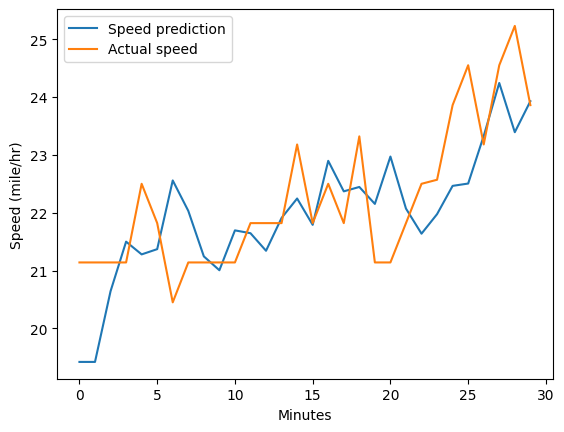

In [316]:
# Create a bar chart of the actual speed values
plt.plot(forecasted_speed10, label='Speed prediction')
plt.plot(test_data.values, label='Actual speed')
plt.xlabel('Minutes')
plt.ylabel('Speed (mile/hr)')
plt.legend()
plt.show()

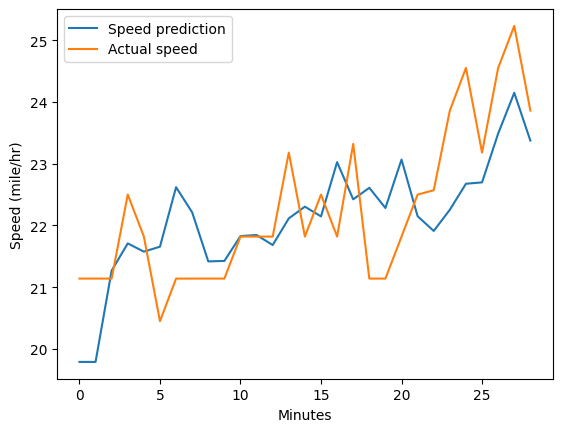

In [317]:
# Create a bar chart of the actual speed values
plt.plot(forecasted_speed20[:-1], label='Speed prediction')
plt.plot(test_data.values[1:], label='Actual speed')
plt.xlabel('Minutes')
plt.ylabel('Speed (mile/hr)')
plt.legend()
plt.show()

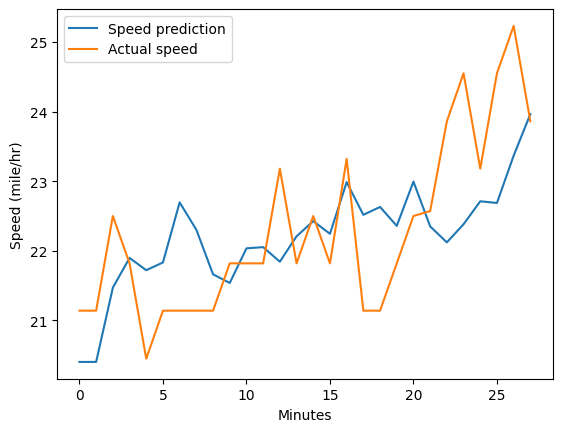

In [318]:
 # Create a bar chart of the actual speed values
plt.plot(forecasted_speed30[:-2], label='Speed prediction')
plt.plot(test_data.values[2:], label='Actual speed')
plt.xlabel('Minutes')
plt.ylabel('Speed (mile/hr)')
plt.legend()
plt.show()

### Far North West

In [321]:
# Split data into train and test sets
train_data = Far_North_West[['bus_count', 'hour', 'speed']].iloc[:-30,:]
test_data = Far_North_West.speed[-30:]

# Create an empty list to store the forecasted values
forecasted_speed10 = []
forecasted_speed20 = []
forecasted_speed30 = []

for i in range(len(test_data)):
    # Create a VAR model with lag order of 2
    model = sm.tsa.VAR(train_data)
    results = model.fit(maxlags=2)

    # Forecast future values
    forecast = results.forecast(train_data.values[-2:], steps=3)
    forecasted_speed10.append(forecast[0][2])
    forecasted_speed20.append(forecast[1][2])
    forecasted_speed30.append(forecast[2][2])

    # Update the train data with the latest values
    
    train_data = Far_North_West[['bus_count', 'hour', 'speed']].iloc[:-30+i,:]


In [322]:
# Calculate RMSE
mse_Fn10 = np.sqrt(np.mean((forecasted_speed10 - test_data.values) ** 2))
mse_Fn20 = np.sqrt(np.mean((forecasted_speed20[:-1] - test_data.values[1:]) ** 2))
mse_Fn30 = np.sqrt(np.mean((forecasted_speed30[:-2] - test_data.values[2:]) ** 2))
print("RMSE For 10 Minutes: ", mse_Fn10)
print("RMSE For 20 Minutes: ", mse_Fn20)
print("RMSE For 30 Minutes: ", mse_Fn30)

RMSE For 10 Minutes:  1.3962839884631073
RMSE For 20 Minutes:  1.663154564631634
RMSE For 30 Minutes:  1.7169850451702322


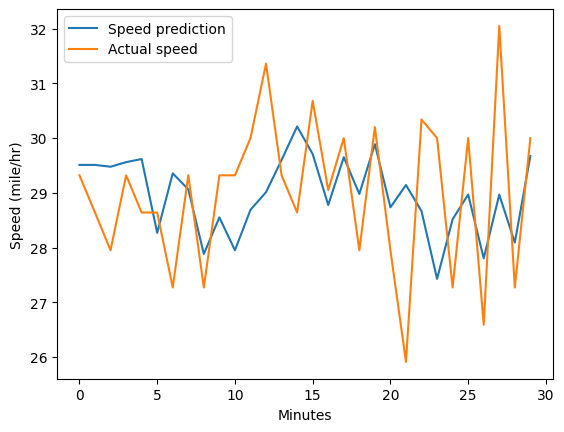

In [323]:
# Create a bar chart of the actual speed values
plt.plot(forecasted_speed10, label='Speed prediction')
plt.plot(test_data.values, label='Actual speed')
plt.xlabel('Minutes')
plt.ylabel('Speed (mile/hr)')
plt.legend()
plt.show()

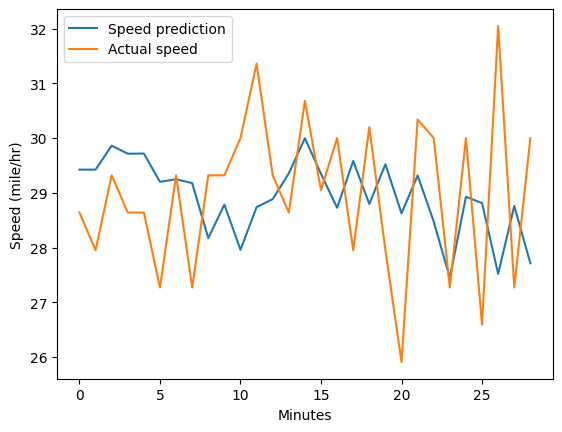

In [324]:
# Create a bar chart of the actual speed values
plt.plot(forecasted_speed20[:-1], label='Speed prediction')
plt.plot(test_data.values[1:], label='Actual speed')
plt.xlabel('Minutes')
plt.ylabel('Speed (mile/hr)')
plt.legend()
plt.show()

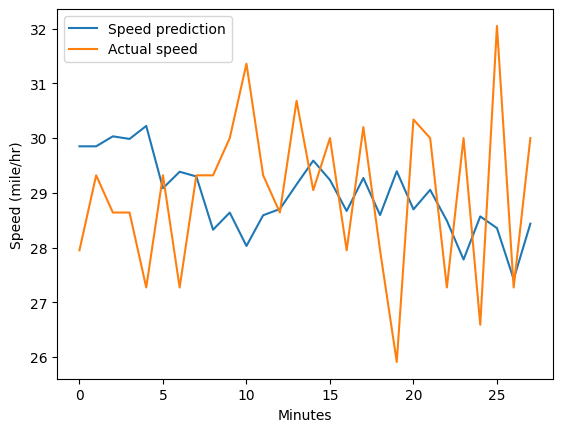

In [325]:
# Create a bar chart of the actual speed values
plt.plot(forecasted_speed30[:-2], label='Speed prediction')
plt.plot(test_data.values[2:], label='Actual speed')
plt.xlabel('Minutes')
plt.ylabel('Speed (mile/hr)')
plt.legend()
plt.show()

### Rogers Park West Ridge

In [328]:
# Split data into train and test sets
train_data = Rogers_Park_West_Ridge[['bus_count', 'hour', 'speed']].iloc[:-30,:]
test_data = Rogers_Park_West_Ridge.speed[-30:]

# Create an empty list to store the forecasted values
forecasted_speed10 = []
forecasted_speed20 = []
forecasted_speed30 = []

for i in range(len(test_data)):
    # Create a VAR model with lag order of 2
    model = sm.tsa.VAR(train_data)
    results = model.fit(maxlags=2)

    # Forecast future values
    forecast = results.forecast(train_data.values[-2:], steps=3)
    forecasted_speed10.append(forecast[0][2])
    forecasted_speed20.append(forecast[1][2])
    forecasted_speed30.append(forecast[2][2])

    # Update the train data with the latest values
    
    train_data = Rogers_Park_West_Ridge[['bus_count', 'hour', 'speed']].iloc[:-30+i,:]



In [329]:
# Calculate RMSE
mse_Rp10 = np.sqrt(np.mean((forecasted_speed10 - test_data.values) ** 2))
mse_Rp20 = np.sqrt(np.mean((forecasted_speed20[:-1] - test_data.values[1:]) ** 2))
mse_Rp30 = np.sqrt(np.mean((forecasted_speed30[:-2] - test_data.values[2:]) ** 2))
print("RMSE For 10 Minutes: ", mse_Rp10)
print("RMSE For 20 Minutes: ", mse_Rp20)
print("RMSE For 30 Minutes: ", mse_Rp30)

RMSE For 10 Minutes:  1.5794537690132369
RMSE For 20 Minutes:  1.6789143367428017
RMSE For 30 Minutes:  1.7455227849653288


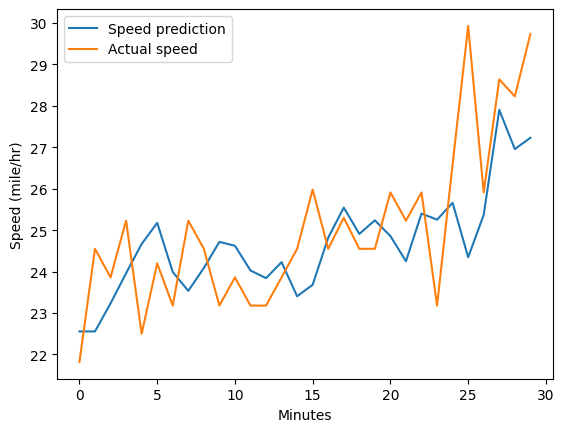

In [330]:
# Create a bar chart of the actual speed values
plt.plot(forecasted_speed10, label='Speed prediction')
plt.plot(test_data.values, label='Actual speed')
plt.xlabel('Minutes')
plt.ylabel('Speed (mile/hr)')
plt.legend()
plt.show()

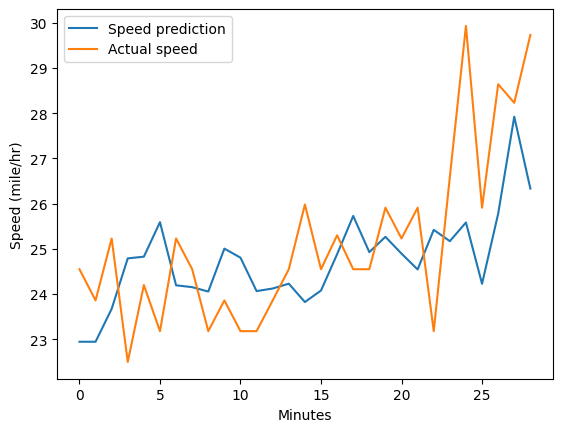

In [331]:
# Create a bar chart of the actual speed values
plt.plot(forecasted_speed20[:-1], label='Speed prediction')
plt.plot(test_data.values[1:], label='Actual speed')
plt.xlabel('Minutes')
plt.ylabel('Speed (mile/hr)')
plt.legend()
plt.show() 

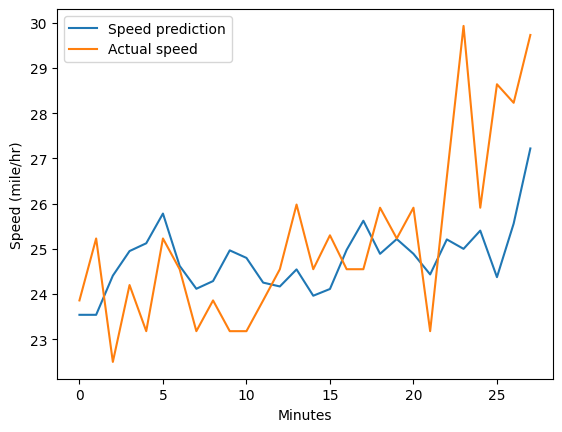

In [332]:
# Create a bar chart of the actual speed values
plt.plot(forecasted_speed30[:-2], label='Speed prediction')
plt.plot(test_data.values[2:], label='Actual speed')
plt.xlabel('Minutes')
plt.ylabel('Speed (mile/hr)')
plt.legend()
plt.show()

### North Park Albany Linconl Sq

In [335]:
# Split data into train and test sets
train_data = North_Park_Albany_Linconl_Sq[['bus_count', 'hour', 'speed']].iloc[:-30,:]
test_data = North_Park_Albany_Linconl_Sq.speed[-30:]

# Create an empty list to store the forecasted values
forecasted_speed10 = []
forecasted_speed20 = []
forecasted_speed30 = []

for i in range(len(test_data)):
    # Create a VAR model with lag order of 2
    model = sm.tsa.VAR(train_data)
    results = model.fit(maxlags=2)

    # Forecast future values
    forecast = results.forecast(train_data.values[-2:], steps=3)
    forecasted_speed10.append(forecast[0][2])
    forecasted_speed20.append(forecast[1][2])
    forecasted_speed30.append(forecast[2][2])

    # Update the train data with the latest values
    
    train_data = North_Park_Albany_Linconl_Sq[['bus_count', 'hour', 'speed']].iloc[:-30+i,:]



In [336]:
# Calculate RMSE
mse_Np10 = np.sqrt(np.mean((forecasted_speed10 - test_data.values) ** 2))
mse_Np20 = np.sqrt(np.mean((forecasted_speed20[:-1] - test_data.values[1:]) ** 2))
mse_Np30 = np.sqrt(np.mean((forecasted_speed30[:-2] - test_data.values[2:]) ** 2))
print("RMSE For 10 Minutes: ", mse_Np10)
print("RMSE For 20 Minutes: ", mse_Np20)
print("RMSE For 30 Minutes: ", mse_Np30)

RMSE For 10 Minutes:  1.2514537931584395
RMSE For 20 Minutes:  1.3115265237468003
RMSE For 30 Minutes:  1.5022381686154922


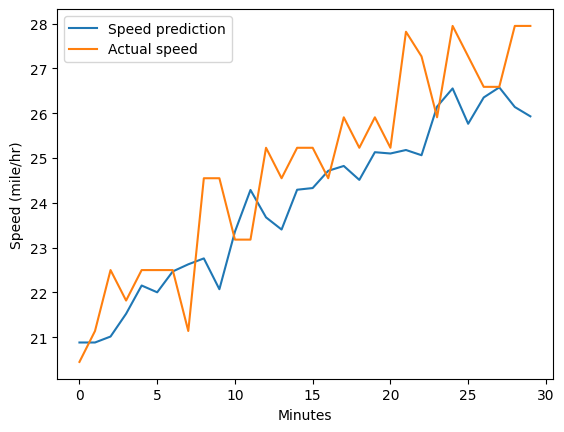

In [337]:
# Create a bar chart of the actual speed values
plt.plot(forecasted_speed10, label='Speed prediction')
plt.plot(test_data.values, label='Actual speed')
plt.xlabel('Minutes')
plt.ylabel('Speed (mile/hr)')
plt.legend()
plt.show()

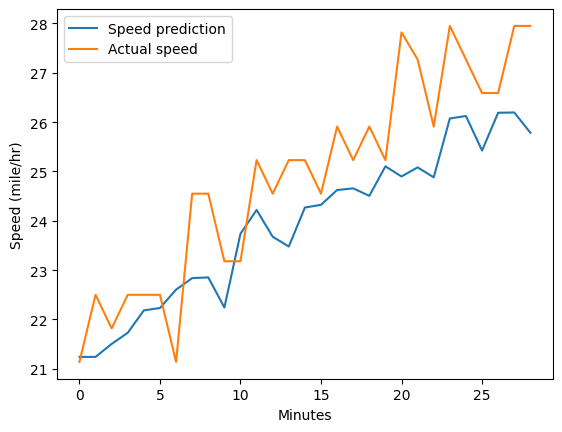

In [338]:
# Create a bar chart of the actual speed values
plt.plot(forecasted_speed20[:-1], label='Speed prediction')
plt.plot(test_data.values[1:], label='Actual speed')
plt.xlabel('Minutes')
plt.ylabel('Speed (mile/hr)')
plt.legend()
plt.show()

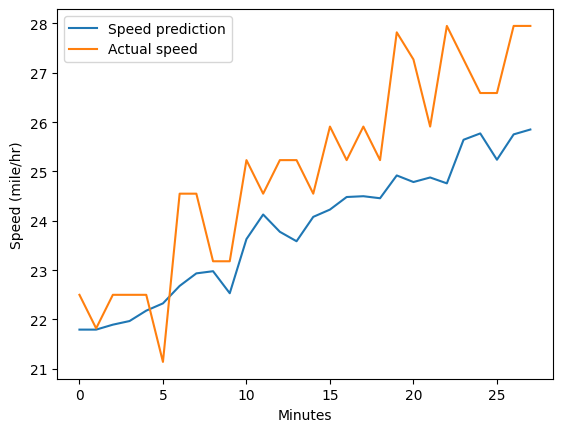

In [339]:
# Create a bar chart of the actual speed values
plt.plot(forecasted_speed30[:-2], label='Speed prediction')
plt.plot(test_data.values[2:], label='Actual speed')
plt.xlabel('Minutes')
plt.ylabel('Speed (mile/hr)')
plt.legend()
plt.show()

In [340]:
performance = pd.DataFrame([[mse_Np10, mse_Np20, mse_Np30],[mse_Rp10, mse_Rp20, mse_Rp30],[mse_Fn10, mse_Fn20, mse_Fn30], [mse_Ew10, mse_Ew20, mse_Ew30]],\
                          columns=pd.MultiIndex.from_product([['RMSE'],['10 min','20 min', '30 min']]),\
                          index=pd.Index(['North Park Albany Linconl Sq','Rogers Park West Ridge','Far North West', 'Edge Water Uptown']))                  
headers = {
    "selector": "th:not(.index_name)",
    "props": "background-color: #2BAF; color: #000000; text-align: center"
}
properties = {"border": "1px solid black", "width": "100px", "text-align": "center"}

perfomance=performance.style.background_gradient(axis=0).format(precision=4).set_table_styles([ headers]).set_properties(**properties)
perfomance